# Import Libraries

In [57]:
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
import datetime
from collections import Counter

sns.set_style("whitegrid")
pd.set_option("display.max_columns", None)
pd.set_option("display.float_format", lambda x: "%.2f" % x)

from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.linear_model import Ridge, Lasso, LinearRegression, ElasticNet
from sklearn.svm import SVR
#from sklearn.kernel_ridge import KernelRidge
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor

from sklearn.feature_selection import f_regression
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import SelectKBest

from IPython.display import Markdown

def bold(string):
    display(Markdown(string))

import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# Load Data

In [3]:
df = pd.read_csv("/mnt/hdd/Datasets/diamonds.csv", index_col=0)
df.head()

carat      cut color clarity  depth  table  price    x    y    z
1   0.23    Ideal     E     SI2  61.50  55.00    326 3.95 3.98 2.43
2   0.21  Premium     E     SI1  59.80  61.00    326 3.89 3.84 2.31
3   0.23     Good     E     VS1  56.90  65.00    327 4.05 4.07 2.31
4   0.29  Premium     I     VS2  62.40  58.00    334 4.20 4.23 2.63
5   0.31     Good     J     SI2  63.30  58.00    335 4.34 4.35 2.75

In [4]:
def df_stats(data):
    print(" SHAPE ".center(50, "#"))
    print("ROWS: {}".format(data.shape[0]))
    print("COLUMNS: {}".format(data.shape[1]))
    print(" TYPES ".center(50, "#"))
    print(data.dtypes)
    print(" MISSING VALUES ".center(50, "#"))
    print(data.isnull().sum())
    print(" DUPLICATED VALUES ".center(50, "#"))
    print("NUMBER OF DUPLICATED VALUES: {}".format(data.duplicated().sum()))
    print(" DESCRIBE ".center(50, "#"))
    print(data.describe().T)

In [5]:
df_stats(df)

##################### SHAPE ######################
ROWS: 53940
COLUMNS: 10
##################### TYPES ######################
carat      float64
cut         object
color       object
clarity     object
depth      float64
table      float64
price        int64
x          float64
y          float64
z          float64
dtype: object
################# MISSING VALUES #################
carat      0
cut        0
color      0
clarity    0
depth      0
table      0
price      0
x          0
y          0
z          0
dtype: int64
############### DUPLICATED VALUES ################
NUMBER OF DUPLICATED VALUES: 146
#################### DESCRIBE ####################
         count    mean     std    min    25%     50%     75%      max
carat 53940.00    0.80    0.47   0.20   0.40    0.70    1.04     5.01
depth 53940.00   61.75    1.43  43.00  61.00   61.80   62.50    79.00
table 53940.00   57.46    2.23  43.00  56.00   57.00   59.00    95.00
price 53940.00 3932.80 3989.44 326.00 950.00 2401.00 5324.25 

# Handling Duplicated Values

In [6]:
df.drop_duplicates(inplace=True)

In [7]:
df.isnull().sum()

carat      0
cut        0
color      0
clarity    0
depth      0
table      0
price      0
x          0
y          0
z          0
dtype: int64

# EDA

In [8]:
df.head()

carat      cut color clarity  depth  table  price    x    y    z
1   0.23    Ideal     E     SI2  61.50  55.00    326 3.95 3.98 2.43
2   0.21  Premium     E     SI1  59.80  61.00    326 3.89 3.84 2.31
3   0.23     Good     E     VS1  56.90  65.00    327 4.05 4.07 2.31
4   0.29  Premium     I     VS2  62.40  58.00    334 4.20 4.23 2.63
5   0.31     Good     J     SI2  63.30  58.00    335 4.34 4.35 2.75

In [9]:
target = "price"
numerical_variables = [col for col in df.columns if pd.api.types.is_numeric_dtype(df[col]) and col != target]
categorical_variables = [col for col in df.columns if pd.api.types.is_categorical_dtype(df[col]) or df[col].dtype == "O" and col != target]

In [10]:
bold("**NUMERICAL VARIABLES**")
print(numerical_variables)

**NUMERICAL VARIABLES**

['carat', 'depth', 'table', 'x', 'y', 'z']


In [11]:
bold("**CATEGORICAL VARIABLES**")
print(categorical_variables)

**CATEGORICAL VARIABLES**

['cut', 'color', 'clarity']


In [12]:
def plot_count(df, col, title):
    fig, ax = plt.subplots(1 ,2, figsize=(18, 6))
    plt.subplots_adjust(wspace=0.2)

    values = df[col].value_counts()
    N = len(values)

    outer_pie = values
    inner_pie = values / N

    ax[0].pie(
        outer_pie,
        labels=values.index.tolist(),
        startangle=90,
        frame=False,
        radius=1.3,
        explode=([0.05] * (N-1) + [0.3]),
        wedgeprops={"linewidth": 1, "edgecolor": "white"},
        textprops={"fontsize": 12, "weight": "bold"}
    )

    ax[0].pie(
        inner_pie,
        radius=1,
        startangle=90,
        autopct="%1.f%%",
        explode=([0.1] * (N-1) + [0.3]),
        pctdistance=0.8,
        textprops={"size": 13, "weight": "bold", "color": "white"}
    )

    center_circle = plt.Circle((0, 0), 0.7, color="black", fc="white", linewidth=0)
    ax[0].add_artist(center_circle)

    sns.barplot(x=values, y=values.index.tolist(), orient="horizontal")

    for i, v in enumerate(values):
        ax[1].text(v, i+0.1, str(v), color="black", fontweight="bold", fontsize=13)

    plt.setp(ax[1].get_yticklabels(), fontweight="bold")
    plt.setp(ax[1].get_xticklabels(), fontweight="bold")
    ax[1].set_xlabel(col, fontweight="bold", color="black")
    ax[1].set_ylabel("count", fontweight="bold", color="black")

    fig.suptitle(f"{title}", fontsize=18, fontweight="bold")
    plt.tight_layout()
    plt.show()

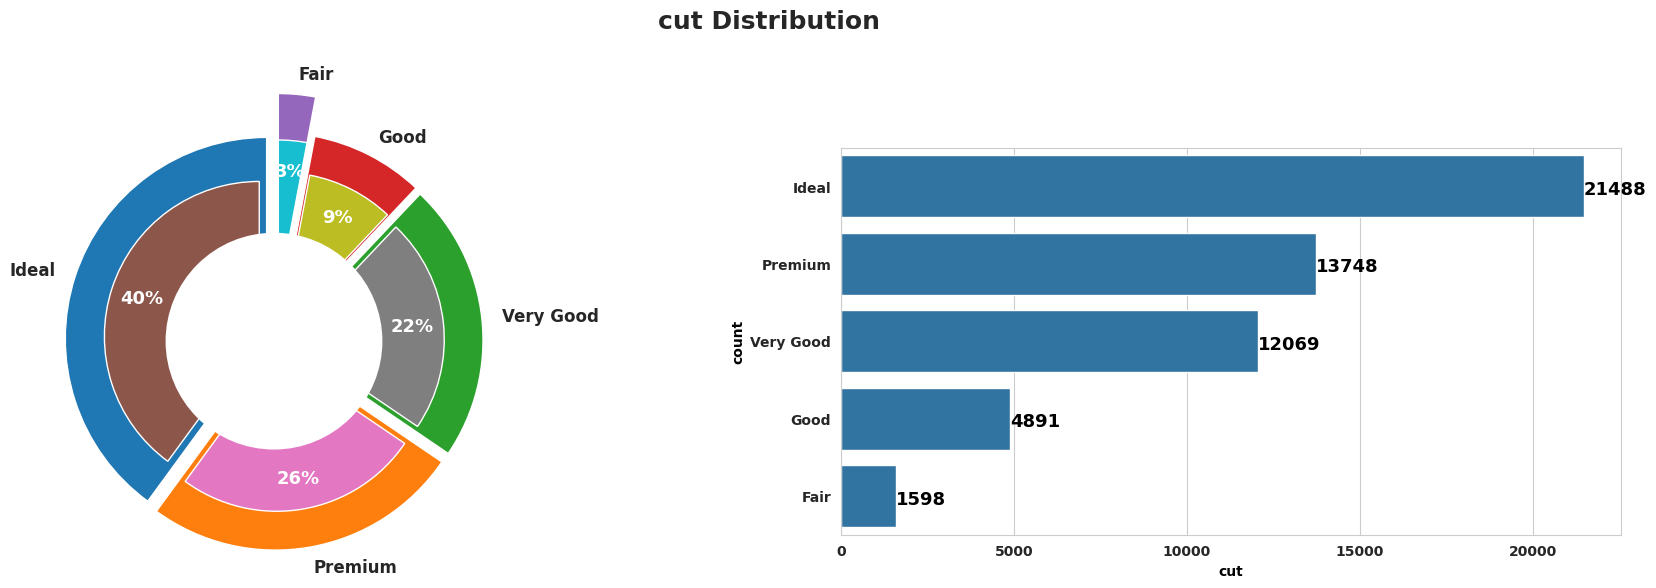

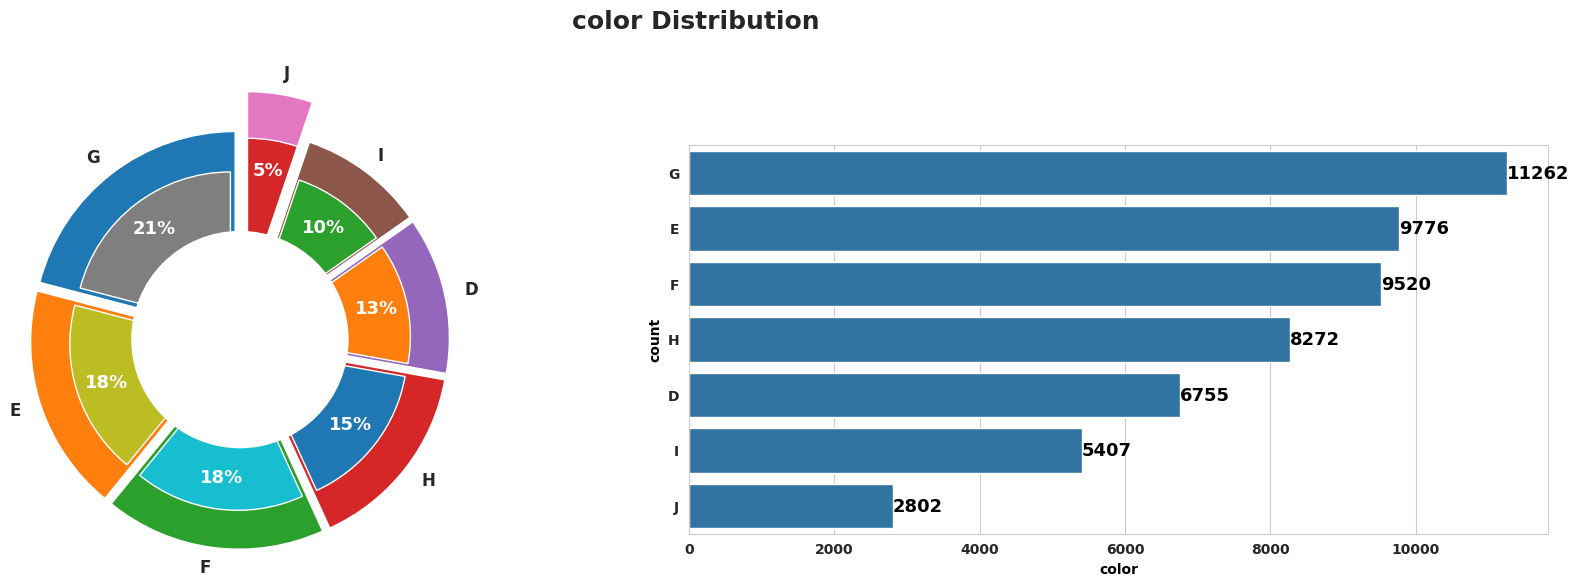

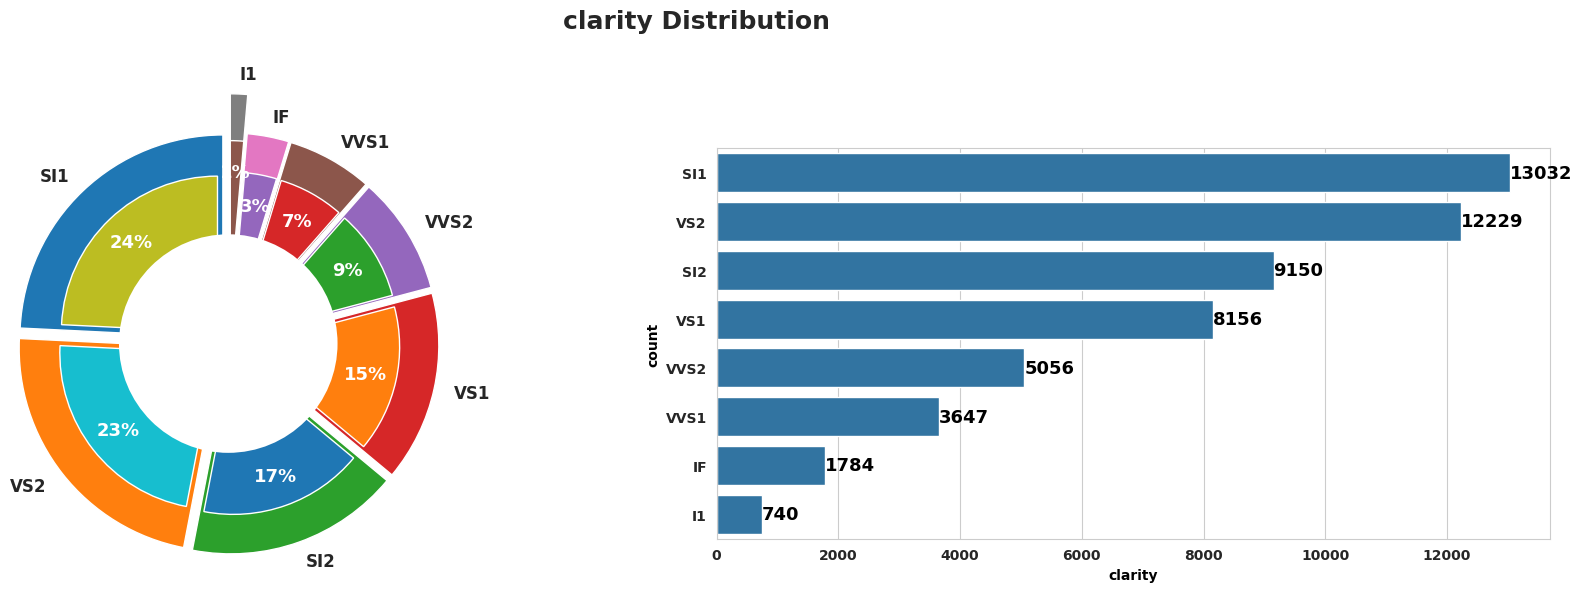

In [13]:
for cat in categorical_variables:
    plot_count(df, cat, f"{cat} Distribution")

In [14]:
def plot_num(df, columns):
    for i, column in enumerate(columns):
        plt.subplot(int(len(columns) / 2) + 1, 2, i + 1)
        sns.histplot(x=column, data=df, bins=30, kde=True)
        plt.axvline(df[column].mean(), color="r", linestyle="--", label="Mean")
        plt.axvline(df[column].median(), color="g", linestyle="-", label="Median")
        plt.grid()
        plt.title(f"{column} Distribution")
        plt.tight_layout()

    plt.show()

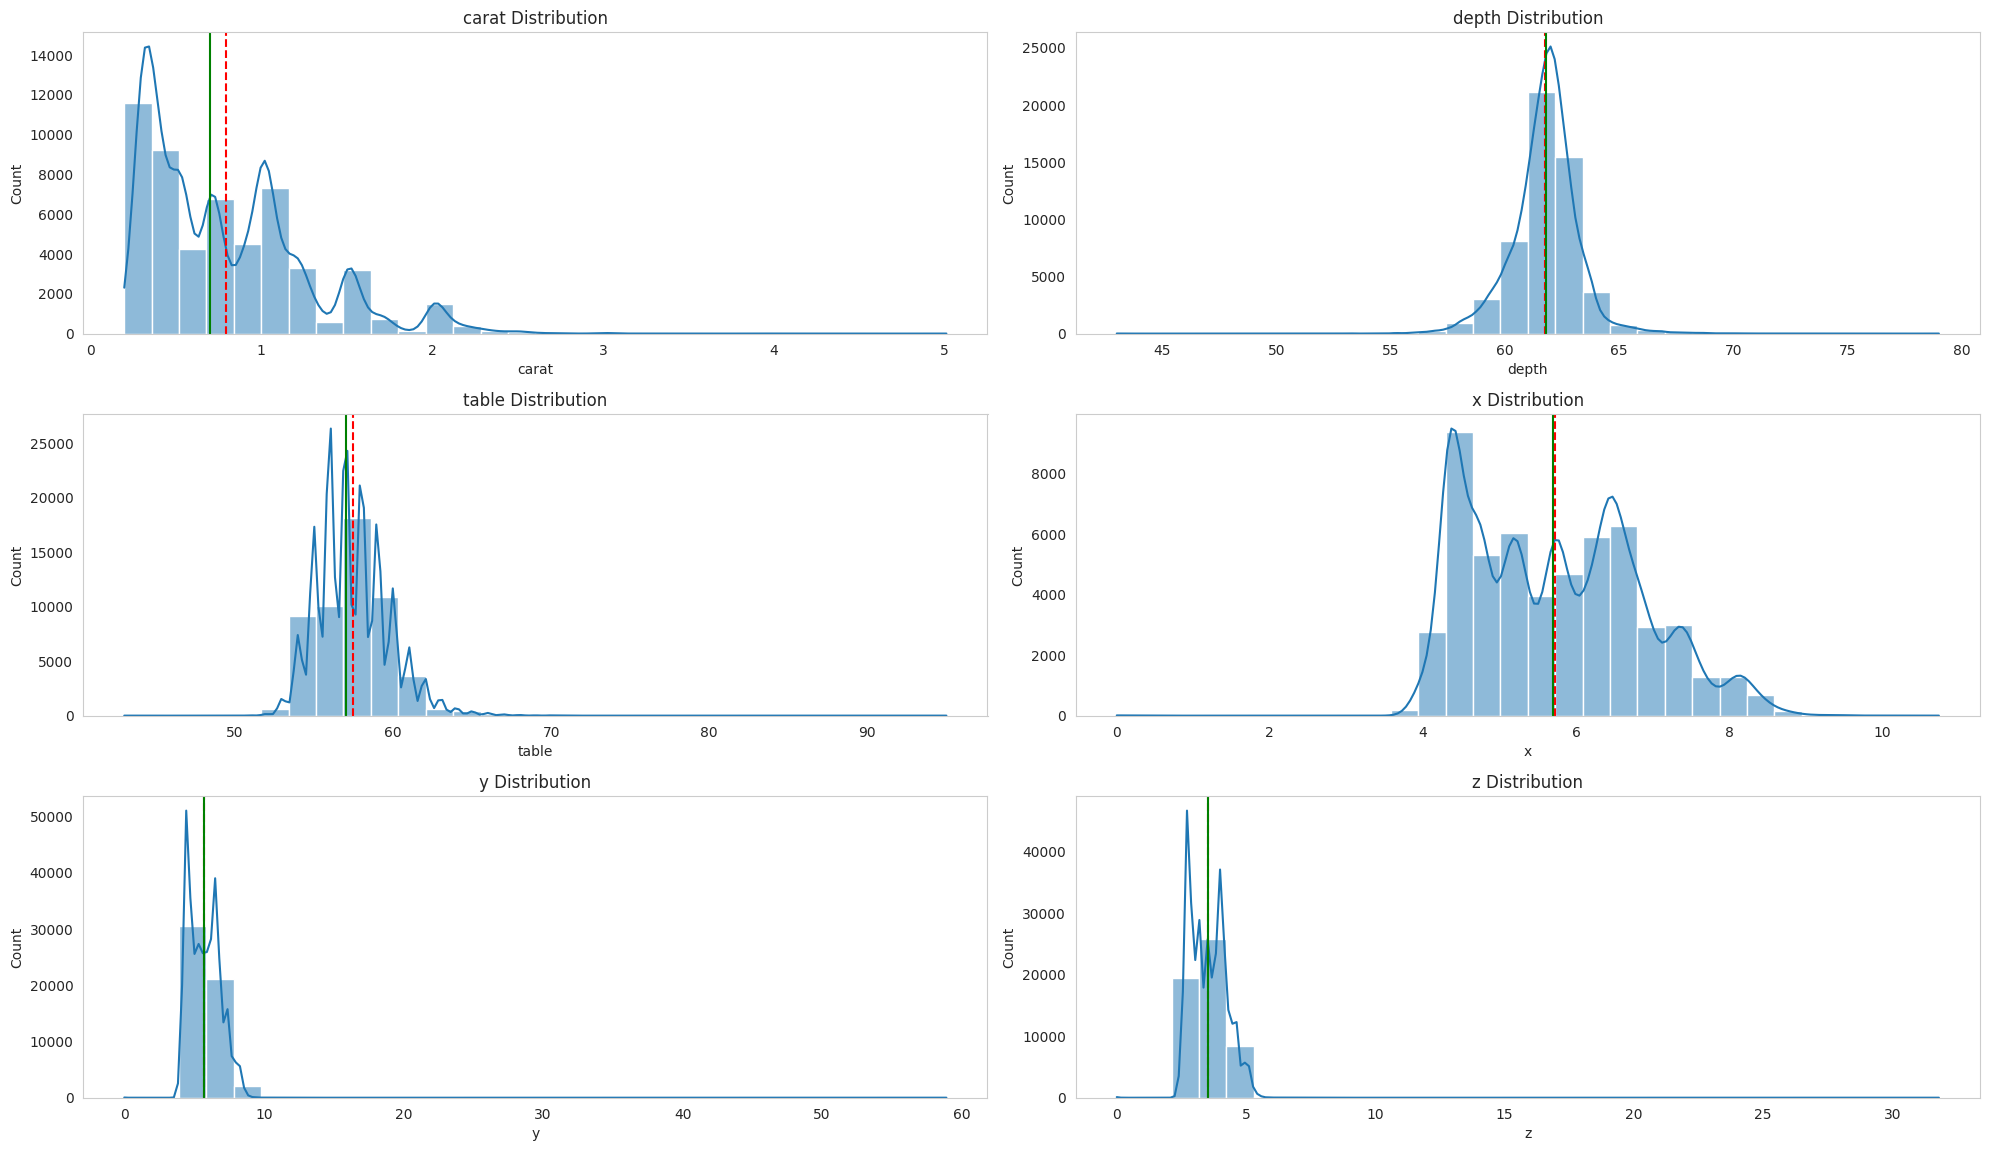

In [15]:
plt.figure(figsize=(20, len(numerical_variables) * 2.5))
plot_num(df, numerical_variables)

In [16]:
def plot_target_num(df, columns, target):
    for i, column in enumerate(columns):
        plt.subplot(int(len(columns) / 2) + 1, 2, i + 1)
        sns.lineplot(data=df, x=column, y=target)
        plt.grid()
        plt.title(f"{column} - price")
        plt.tight_layout()

    plt.show()

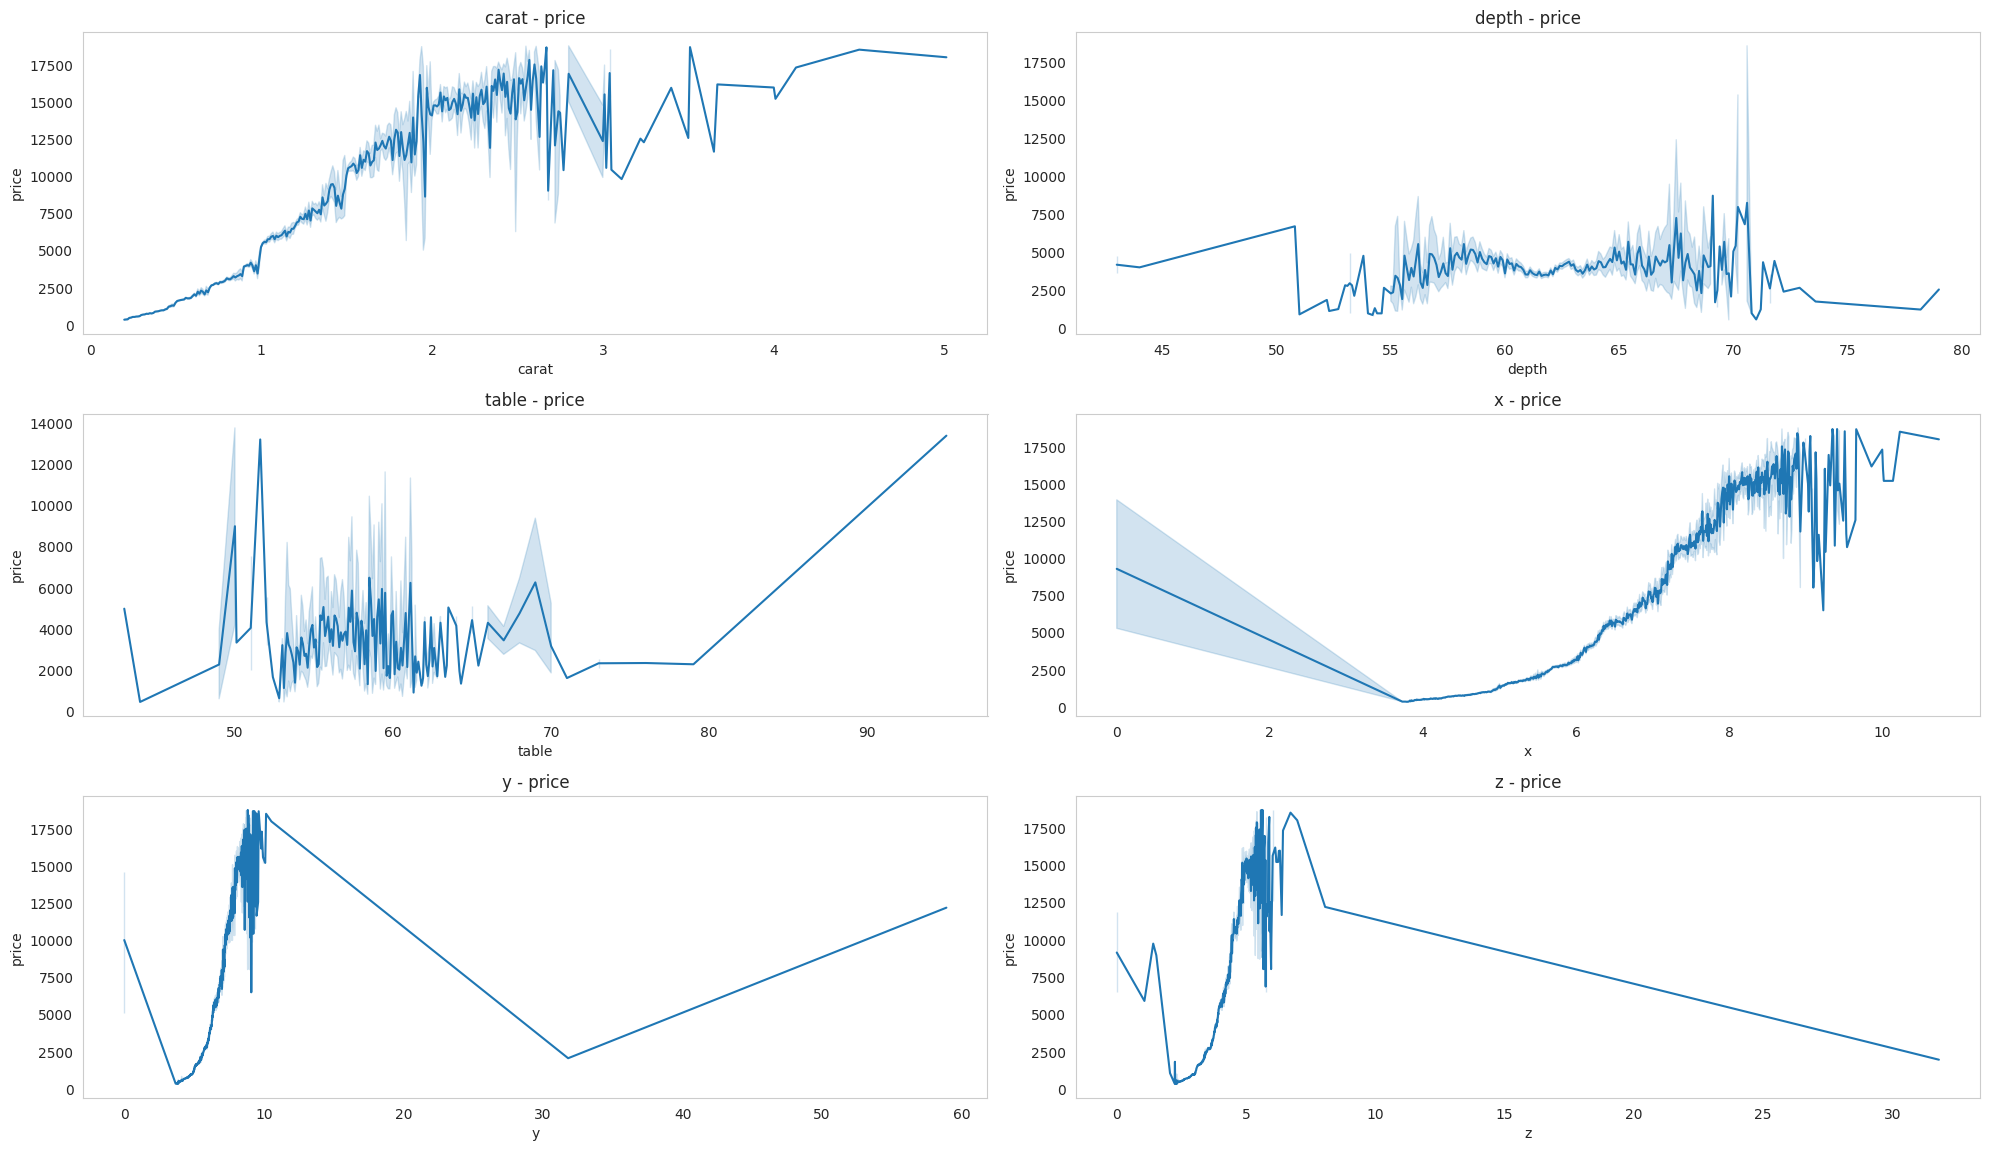

In [17]:
plt.figure(figsize=(20, len(numerical_variables) * 2.5))
plot_target_num(df, numerical_variables, target)

# Outlier Detection

In [18]:
def custom_boxplot(df, columns, title):
    fig, ax = plt.subplots(int(len(columns) / 2) , 2, sharey=True, figsize=(15, len(columns) * 2.5))
    fig.suptitle(title, y=1, size=25)
    ax = ax.flatten()
    for i, column in enumerate(columns):
        sns.boxplot(data=df[column], orient="h", ax=ax[i])
        ax[i].set_title(column + ", skewness is: " + str(round(df[column].skew(axis=0, skipna=True), 2)))

    plt.tight_layout()
    plt.show()

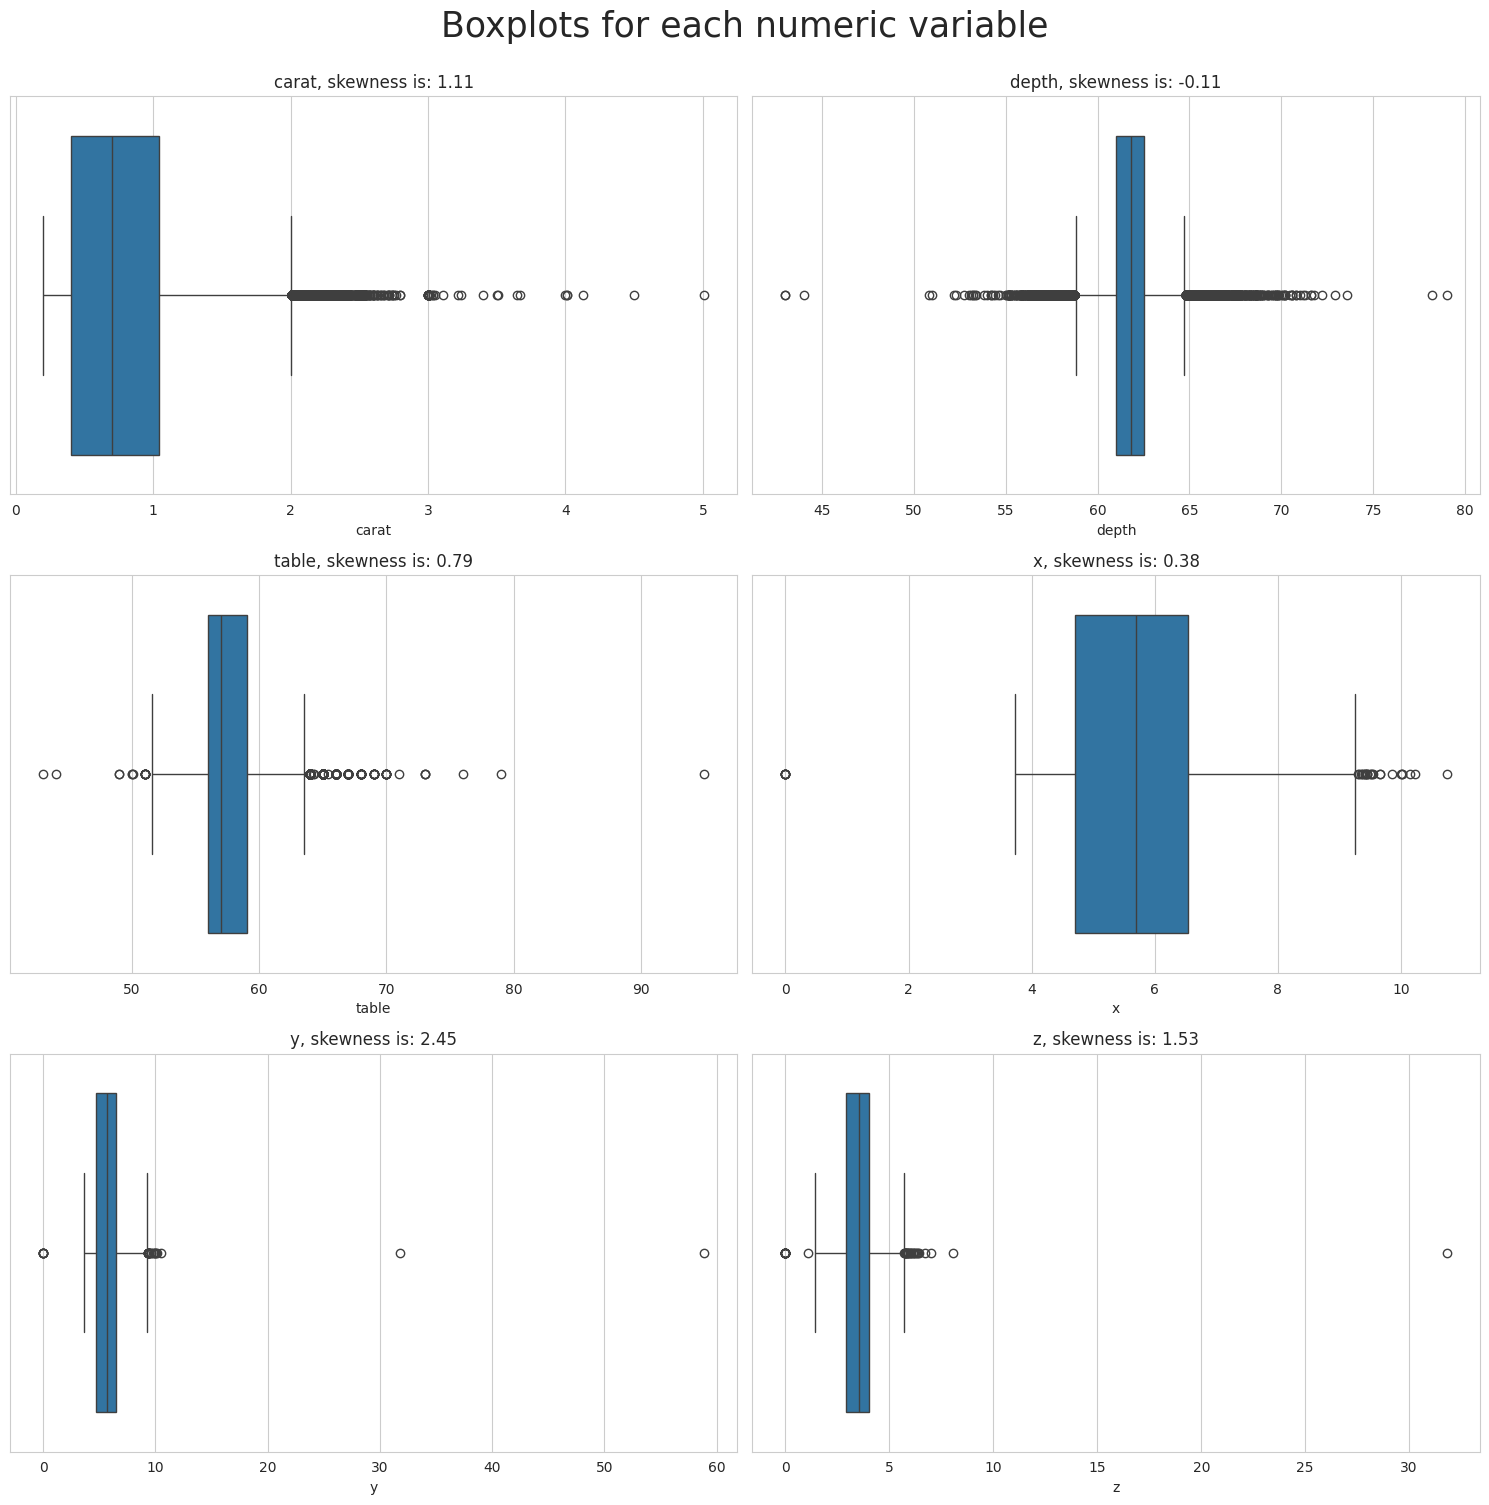

In [19]:
custom_boxplot(df, numerical_variables, "Boxplots for each numeric variable")

In [20]:
df = df[(df["carat"] <= 2) & (df["depth"] <= 64) & (df["depth"] >= 59) & (df["table"] >= 51) & (df["table"] <= 62) & (df["x"] != 0) & (df["x"] <= 9) & (df["y"] <= 9) & (df["y"] != 0) & (df["z"] <= 6) & (df["z"] >= 2)].reset_index(drop=True)

In [21]:
df.shape

(47663, 10)

# Feature Scaling

In [22]:
df.head()

carat        cut color clarity  depth  table  price    x    y    z
0   0.23      Ideal     E     SI2  61.50  55.00    326 3.95 3.98 2.43
1   0.21    Premium     E     SI1  59.80  61.00    326 3.89 3.84 2.31
2   0.29    Premium     I     VS2  62.40  58.00    334 4.20 4.23 2.63
3   0.31       Good     J     SI2  63.30  58.00    335 4.34 4.35 2.75
4   0.24  Very Good     J    VVS2  62.80  57.00    336 3.94 3.96 2.48

In [23]:
def list_uniq(df, columns):
    for column in columns:
        print(f" {column} ".center(30, "#"))
        for i, val in enumerate(df[column].unique()):
            print(f"{i+1}. {val}")

        print()

In [24]:
list_uniq(df, categorical_variables)

############ cut #############
1. Ideal
2. Premium
3. Good
4. Very Good
5. Fair

########### color ############
1. E
2. I
3. J
4. H
5. F
6. G
7. D

########## clarity ###########
1. SI2
2. SI1
3. VS2
4. VVS2
5. VVS1
6. VS1
7. I1
8. IF



In [25]:
X = df.drop("price", axis=1)
y = df["price"]

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

In [27]:
encoder = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
X_train["cut"] = encoder.fit_transform(X_train["cut"].values.reshape(-1, 1))[:, 0]
X_train["color"] = encoder.fit_transform(X_train["color"].values.reshape(-1, 1))[:, 0]
X_train["clarity"] = encoder.fit_transform(X_train["clarity"].values.reshape(-1, 1))[:, 0]

In [28]:
X_test["cut"] = encoder.transform(X_test["cut"].values.reshape(-1, 1))[:, 0]
X_test["color"] = encoder.transform(X_test["color"].values.reshape(-1, 1))[:, 0]
X_test["clarity"] = encoder.transform(X_test["clarity"].values.reshape(-1, 1))[:, 0]

In [29]:
numerical_variables

['carat', 'depth', 'table', 'x', 'y', 'z']

In [30]:
ss = StandardScaler()
X_train[numerical_variables] = ss.fit_transform(X_train[numerical_variables])

In [31]:
X_test[numerical_variables] = ss.transform(X_test[numerical_variables])

# Model

In [32]:
def adjusted_r2(r2, n, k):
    return r2 - (k - 1) / (n - k) * (1 - r2)

In [33]:
def root_mse(y_test, y_pred):
    return np.sqrt(mean_squared_error(y_test, y_pred))

In [34]:
kf = KFold(n_splits=5, shuffle=False)

In [35]:
scores_df = pd.DataFrame({
    "Model": [],
    "R2": [],
    "Adjusted R2": [],
    "MSE": [],
    "RMSE": [],
    "MAE": []
})

In [36]:
lr = LinearRegression()
ridge = Ridge()
lasso = Lasso()
en = ElasticNet()
svr = SVR()
rf = RandomForestRegressor()
gb = GradientBoostingRegressor()
ada = AdaBoostRegressor()
xgb = XGBRegressor()
lgbm = LGBMRegressor()
knn = KNeighborsRegressor()

In [37]:
def add_to_scores_df(log, model_name, idx):
    scores_df.loc[idx] = [model_name, log["R2"][0], log["Adjusted R2"][0], log["MSE"][0], log["RMSE"][0], log["MAE"][0]]

In [38]:
def train_model(model):
    model_log = pd.DataFrame(columns=["R2", "Adjusted R2", "MSE", "RMSE", "MAE"])
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    model_log.loc[0, "R2"] = r2_score(y_test, y_pred)
    model_log.loc[0, "Adjusted R2"] = adjusted_r2(r2_score(y_test, y_pred), X.shape[0], X.shape[1])
    model_log.loc[0, "MSE"] = mean_squared_error(y_test, y_pred)
    model_log.loc[0, "RMSE"] = root_mse(y_test, y_pred)
    model_log.loc[0, "MAE"] = mean_absolute_error(y_test, y_pred)

    fig, ax = plt.subplots(figsize=(8, 6))
    sns.regplot(x=y_test, y=y_pred)
    plt.show()

    return model_log

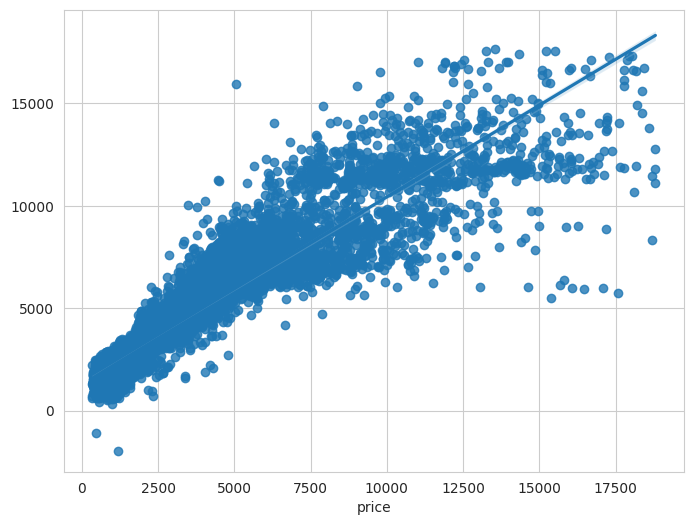

R2 Adjusted R2        MSE    RMSE     MAE
0 0.76        0.76 2859610.84 1691.04 1385.76

In [39]:
lr_log = train_model(lr)
add_to_scores_df(lr_log, "Linear Regression", 0)
lr_log

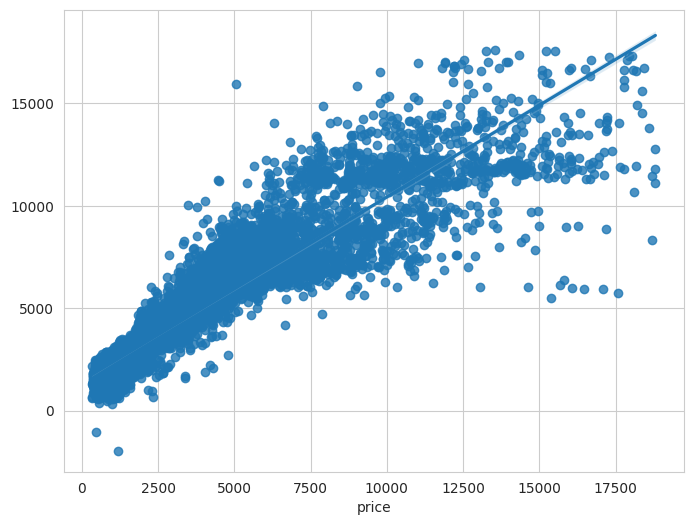

R2 Adjusted R2        MSE    RMSE     MAE
0 0.76        0.76 2857137.90 1690.31 1384.99

In [40]:
ridge_log = train_model(ridge)
add_to_scores_df(ridge_log, "Ridge", 1)
ridge_log

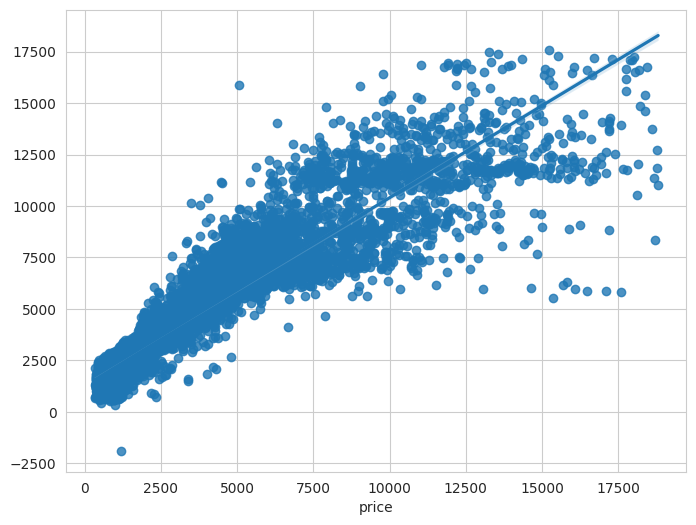

R2 Adjusted R2        MSE    RMSE     MAE
0 0.76        0.76 2814195.64 1677.56 1369.63

In [41]:
lasso_log = train_model(lasso)
add_to_scores_df(lasso_log, "Lasso", 2)
lasso_log

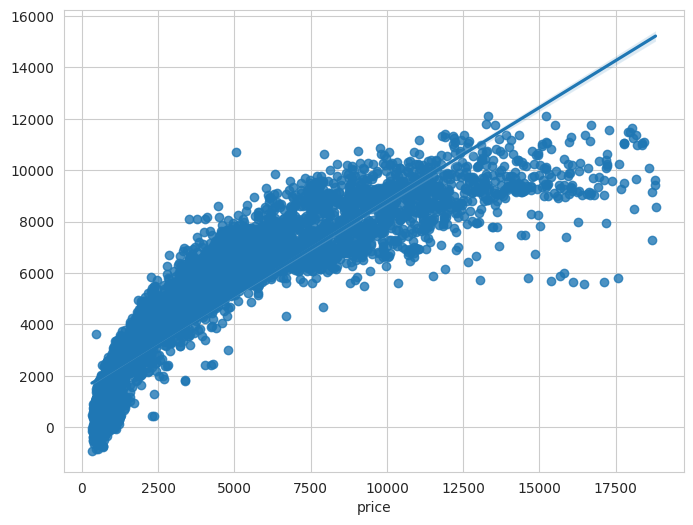

R2 Adjusted R2        MSE    RMSE     MAE
0 0.78        0.78 2612152.31 1616.22 1207.32

In [42]:
en_log = train_model(en)
add_to_scores_df(en_log, "ElasticNet", 3)
en_log

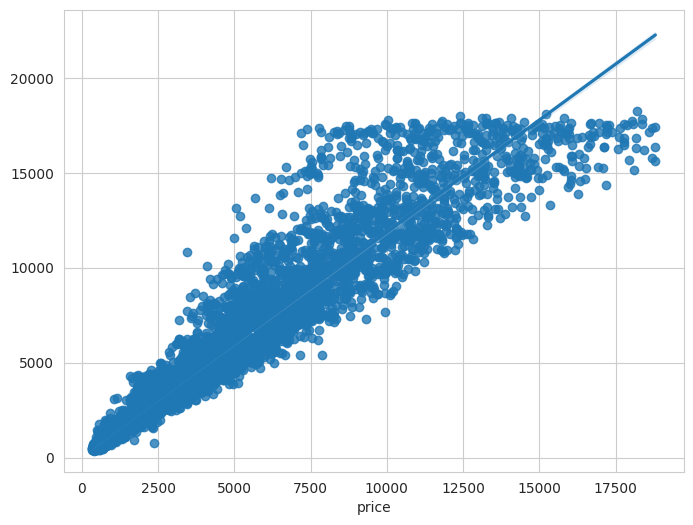

R2 Adjusted R2        MSE    RMSE    MAE
0 0.81        0.81 2239791.70 1496.59 800.29

In [43]:
rf_log = train_model(rf)
add_to_scores_df(rf_log, "Random Forests", 4)
rf_log

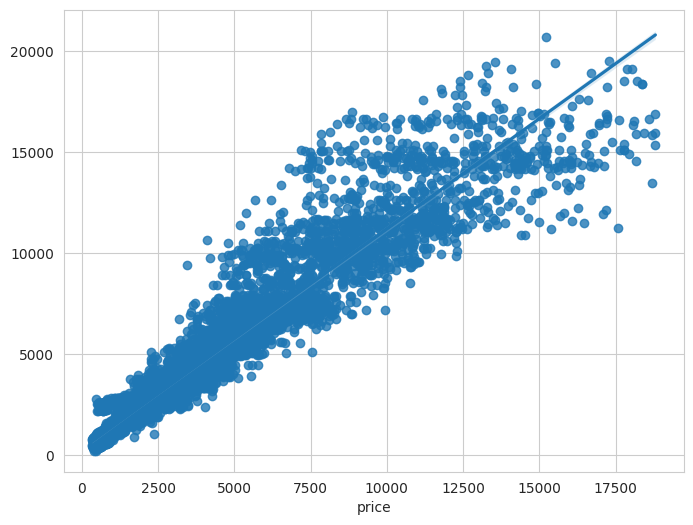

R2 Adjusted R2        MSE    RMSE    MAE
0 0.86        0.86 1662543.93 1289.40 743.17

In [44]:
gb_log = train_model(gb)
add_to_scores_df(gb_log, "Gradient Boosting", 5)
gb_log

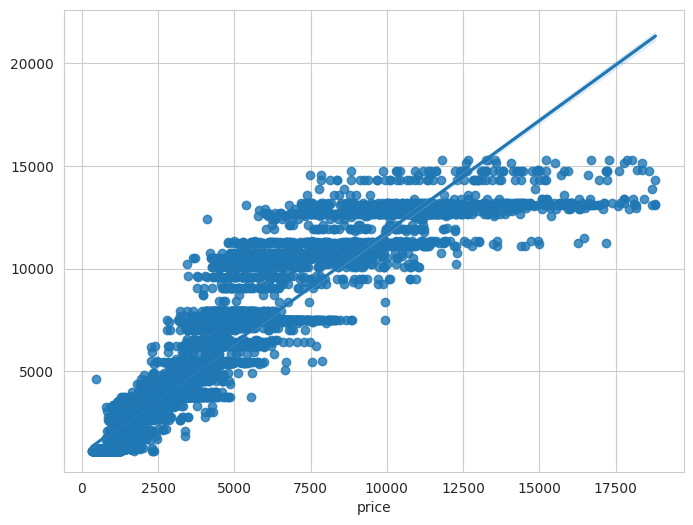

R2 Adjusted R2        MSE    RMSE     MAE
0 0.69        0.69 3699992.97 1923.54 1369.02

In [45]:
ada_log = train_model(ada)
add_to_scores_df(ada_log, "Ada Boost", 6)
ada_log

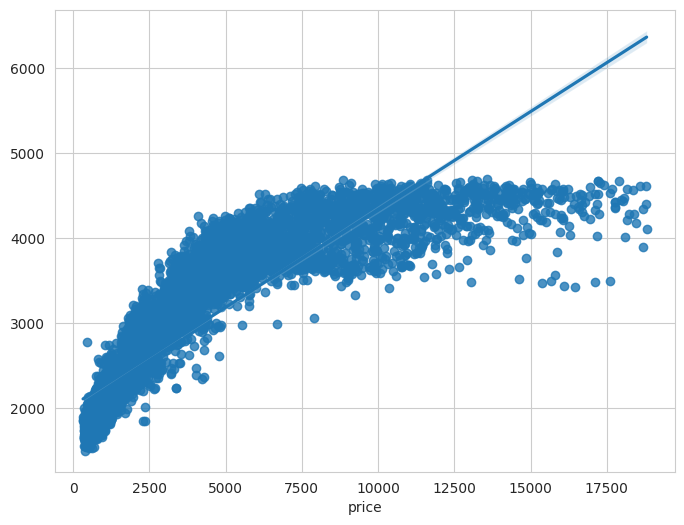

R2 Adjusted R2        MSE    RMSE     MAE
0 0.36        0.36 7610843.89 2758.78 1741.17

In [46]:
svr_log = train_model(svr)
add_to_scores_df(svr_log, "SVR", 7)
svr_log

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001618 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1099
[LightGBM] [Info] Number of data points in the train set: 38130, number of used features: 9
[LightGBM] [Info] Start training from score 3509.565303


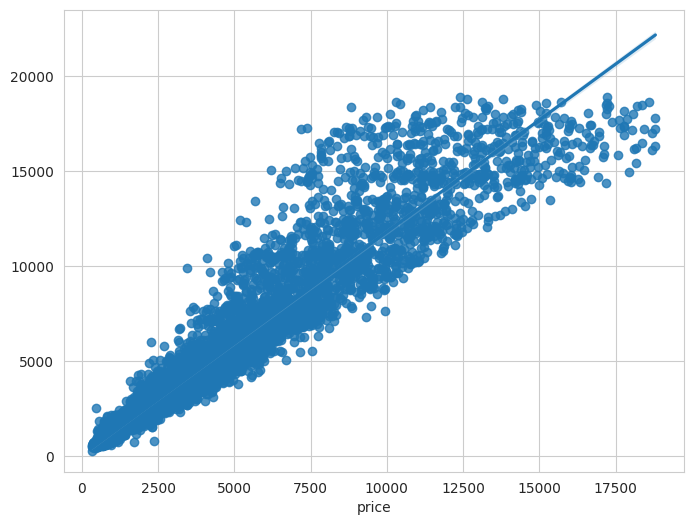

R2 Adjusted R2        MSE    RMSE    MAE
0 0.82        0.82 2110535.64 1452.77 749.45

In [47]:
lgbm_log = train_model(lgbm)
add_to_scores_df(lgbm_log, "LGBM", 8)
lgbm_log

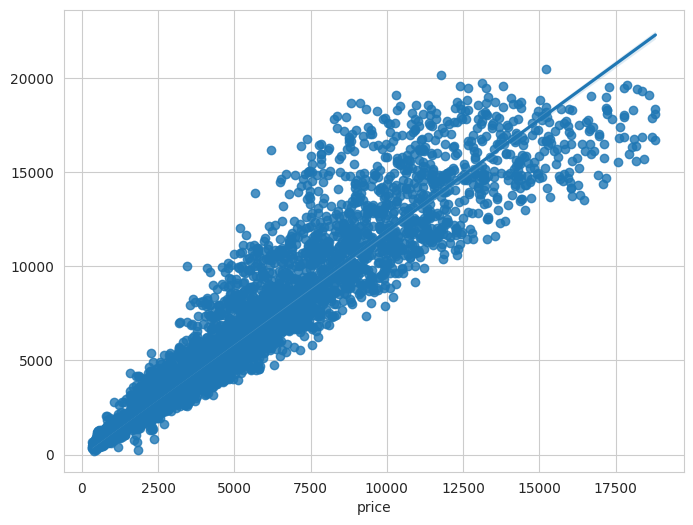

R2 Adjusted R2        MSE    RMSE    MAE
0 0.82        0.82 2186786.38 1478.78 766.84

In [48]:
xgb_log = train_model(xgb)
add_to_scores_df(xgb_log, "XGBoost", 9)
xgb_log

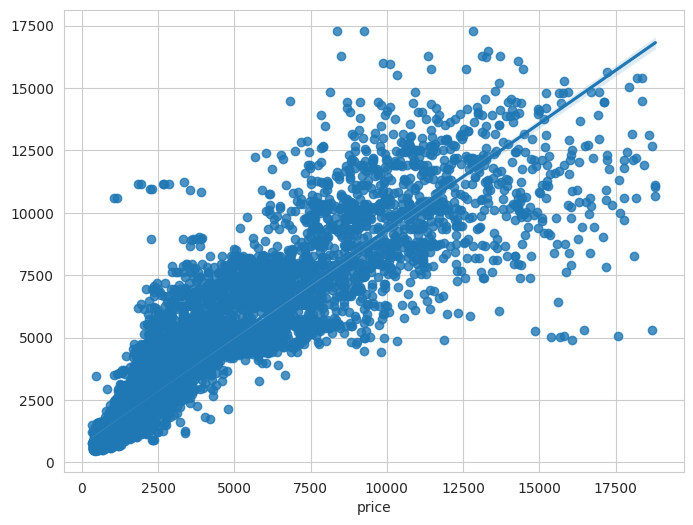

R2 Adjusted R2        MSE    RMSE    MAE
0 0.82        0.82 2127880.70 1458.73 882.61

In [51]:
knn_log = train_model(knn)
add_to_scores_df(knn_log, "KNeighbors", 10)
knn_log

In [52]:
scores_df

Model   R2  Adjusted R2        MSE    RMSE     MAE
0   Linear Regression 0.76         0.76 2859610.84 1691.04 1385.76
1               Ridge 0.76         0.76 2857137.90 1690.31 1384.99
2               Lasso 0.76         0.76 2814195.64 1677.56 1369.63
3          ElasticNet 0.78         0.78 2612152.31 1616.22 1207.32
4      Random Forests 0.81         0.81 2239791.70 1496.59  800.29
5   Gradient Boosting 0.86         0.86 1662543.93 1289.40  743.17
6           Ada Boost 0.69         0.69 3699992.97 1923.54 1369.02
7                 SVR 0.36         0.36 7610843.89 2758.78 1741.17
8                LGBM 0.82         0.82 2110535.64 1452.77  749.45
9             XGBoost 0.82         0.82 2186786.38 1478.78  766.84
10         KNeighbors 0.82         0.82 2127880.70 1458.73  882.61

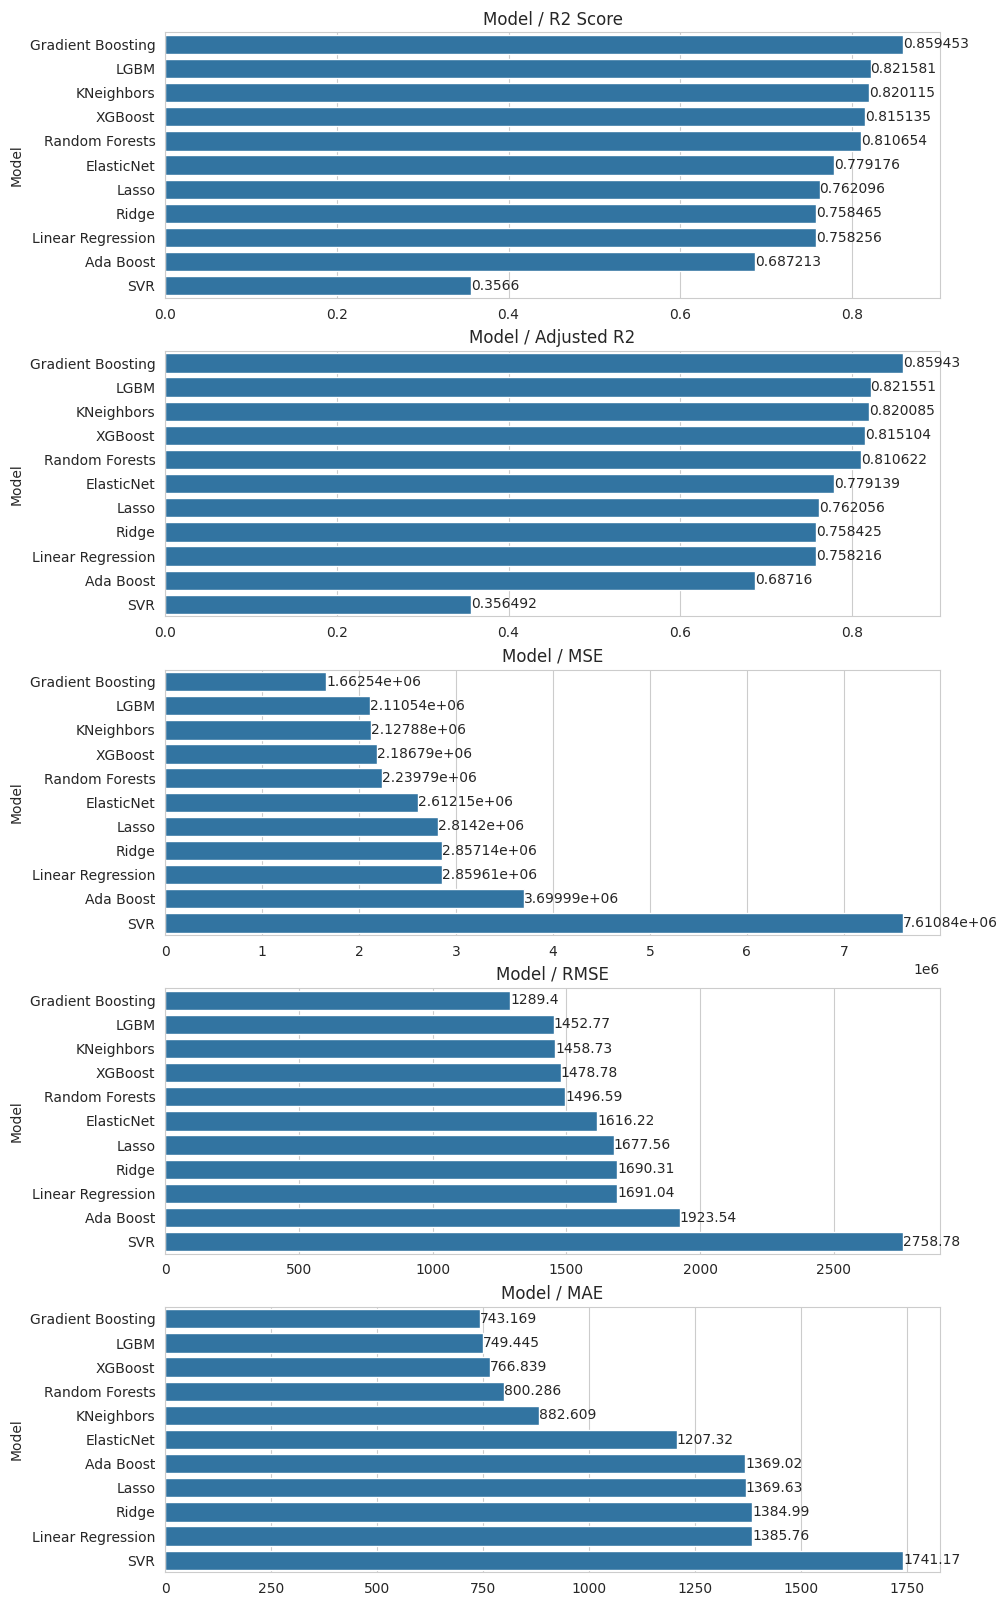

In [54]:
plt.figure(figsize=(10, 20))

plt.subplot(511)
ax = sns.barplot(data=scores_df.sort_values(by="R2", ascending=False), y="Model", x="R2")
for container in ax.containers:
    ax.bar_label(container)
plt.title("Model / R2 Score")
plt.xlabel("")

plt.subplot(512)
ax = sns.barplot(data=scores_df.sort_values(by="Adjusted R2", ascending=False), y="Model", x="Adjusted R2")
for container in ax.containers:
    ax.bar_label(container)
plt.title("Model / Adjusted R2")
plt.xlabel("")

plt.subplot(513)
ax = sns.barplot(data=scores_df.sort_values(by="MSE", ascending=True), y="Model", x="MSE")
for container in ax.containers:
    ax.bar_label(container)
plt.title("Model / MSE")
plt.xlabel("")

plt.subplot(514)
ax = sns.barplot(data=scores_df.sort_values(by="RMSE", ascending=True), y="Model", x="RMSE")
for container in ax.containers:
    ax.bar_label(container)
plt.title("Model / RMSE")
plt.xlabel("")

plt.subplot(515)
ax = sns.barplot(data=scores_df.sort_values(by="MAE", ascending=True), y="Model", x="MAE")
for container in ax.containers:
    ax.bar_label(container)
plt.title("Model / MAE")
plt.xlabel("")

plt.show()

# Feature Selection

In [55]:
def plot_correlation_table(df):
    corr = df.corr()
    fig, axes = plt.subplots(figsize=(20, 20))
    mask = np.triu(np.ones_like(corr))
    sns.heatmap(corr, mask=mask, linewidth=0.6, annot=True, robust=True, center=0, square=True)
    plt.title("Correlation Table")
    plt.show()

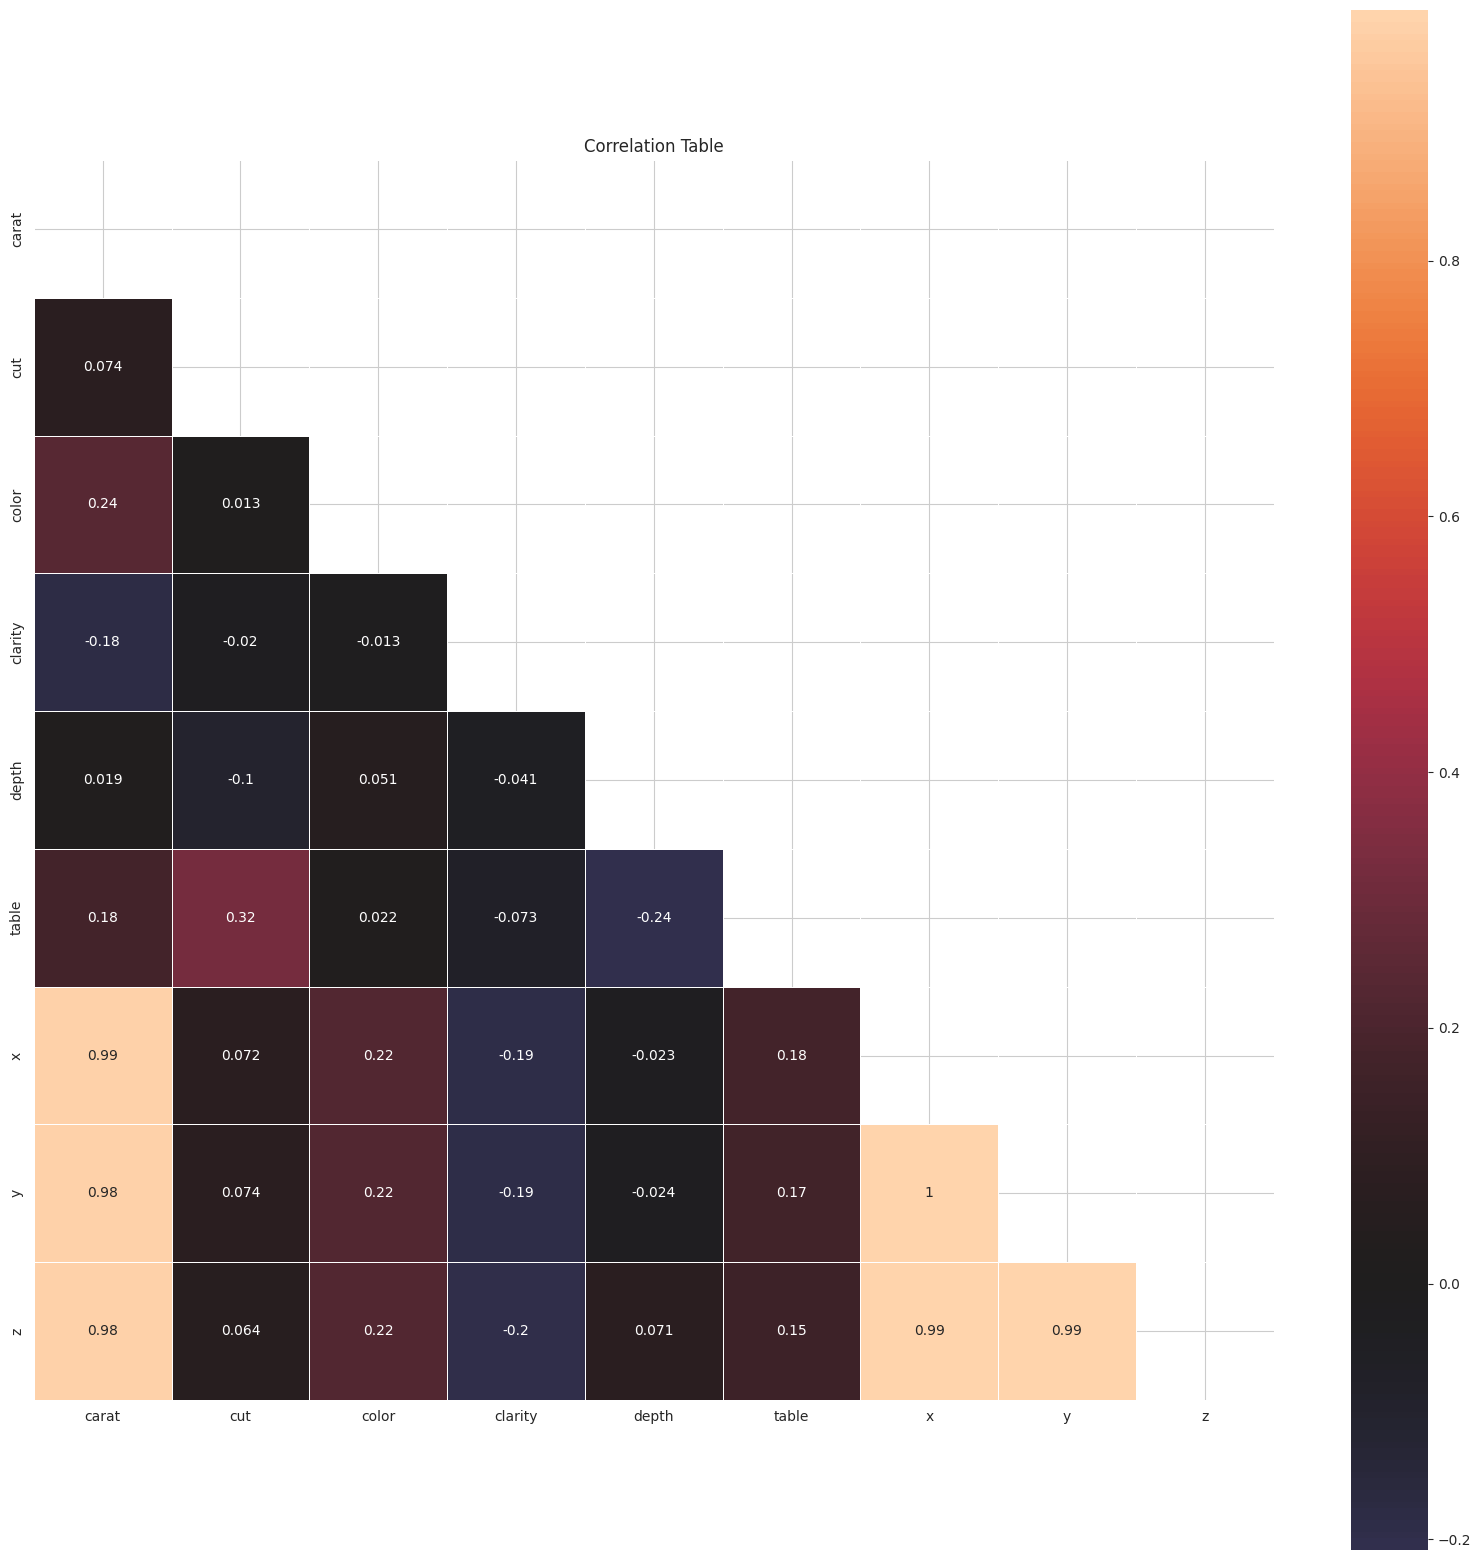

In [56]:
plot_correlation_table(X_train)

In [58]:
f_value = f_regression(X_train, y_train)

for feature in zip(X_train.columns, f_value[0]):
    print(feature)

('carat', 184739.89405391915)
('cut', 97.43162288227963)
('color', 395.07213675918905)
('clarity', 31.76680036513657)
('depth', 1.825768730596988)
('table', 579.8595709042219)
('x', 126102.05254717346)
('y', 127579.60642191826)
('z', 123628.98902425753)


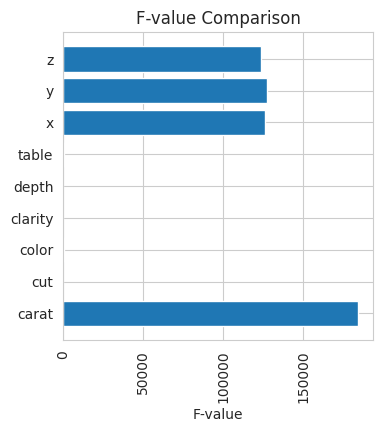

In [66]:
plt.figure(figsize=(4, 4))
plt.barh(y=X_train.columns, width=f_value[0])
plt.xticks(rotation="vertical")
plt.xlabel("F-value")
plt.title("F-value Comparison")
plt.show()

In [67]:
MI_score = mutual_info_regression(X_train, y_train, random_state=42)

for feature in zip(X_train.columns, MI_score):
    print(feature)

('carat', 1.932867494407946)
('cut', 0.08931877655432352)
('color', 0.28497749139684636)
('clarity', 0.3782061917587183)
('depth', 0.01965644752646689)
('table', 0.04367728669933291)
('x', 1.4527751128475934)
('y', 1.4478078233718596)
('z', 1.4220980472852798)


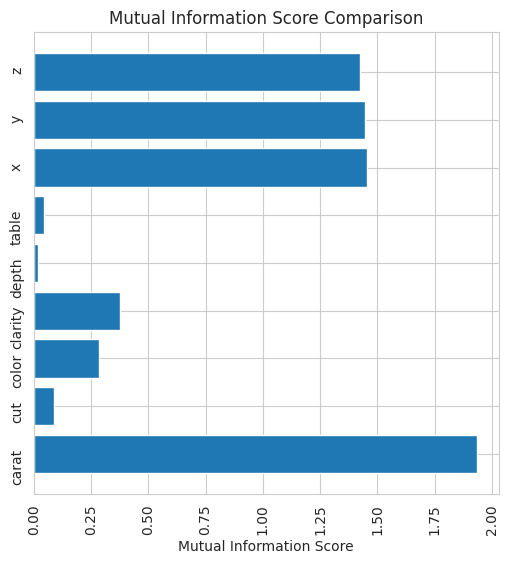

In [70]:
plt.figure(figsize=(6, 6))
plt.barh(y=X_train.columns, width=MI_score)
plt.xticks(rotation="vertical")
plt.yticks(rotation="vertical")
plt.xlabel("Mutual Information Score")
plt.title("Mutual Information Score Comparison")
plt.show()

In [87]:
skb = SelectKBest(score_func=f_regression, k=5)                  
X_data_new = skb.fit_transform(X_train, y_train)

print('Number of features before feature selection: {}'.format(X_train.shape[1]))
print('Number of features after feature selection: {}'.format(X_data_new.shape[1]))

for feature_list_index in skb.get_support(indices=True):
    print('- ' + X_train.columns[feature_list_index])

Number of features before feature selection: 9
Number of features after feature selection: 5
- carat
- table
- x
- y
- z


In [88]:
drop_cols = ["clarity", "depth", "cut", "color"]
X_train_new = X_train.drop(columns=drop_cols, axis=1)
X_test_new = X_test.drop(columns=drop_cols, axis=1)

In [79]:
f_scores_df = pd.DataFrame({
    "Model": [],
    "R2": [],
    "Adjusted R2": [],
    "MSE": [],
    "RMSE": [],
    "MAE": []
})

In [90]:
f_lr = LinearRegression()
f_ridge = Ridge()
f_lasso = Lasso()
f_en = ElasticNet()
f_svr = SVR()
f_rf = RandomForestRegressor()
f_gb = GradientBoostingRegressor()
f_ada = AdaBoostRegressor()
f_xgb = XGBRegressor()
f_lgbm = LGBMRegressor()
f_knn = KNeighborsRegressor()

In [81]:
def add_to_f_scores_df(log, model_name, idx):
    f_scores_df.loc[idx] = [model_name, log["R2"][0], log["Adjusted R2"][0], log["MSE"][0], log["RMSE"][0], log["MAE"][0]]

In [93]:
def train_model(model):
    model_log = pd.DataFrame(columns=["R2", "Adjusted R2", "MSE", "RMSE", "MAE"])
    model.fit(X_train_new, y_train)

    y_pred = model.predict(X_test_new)

    model_log.loc[0, "R2"] = r2_score(y_test, y_pred)
    model_log.loc[0, "Adjusted R2"] = adjusted_r2(r2_score(y_test, y_pred), X_train_new.shape[0], X_train_new.shape[1])
    model_log.loc[0, "MSE"] = mean_squared_error(y_test, y_pred)
    model_log.loc[0, "RMSE"] = root_mse(y_test, y_pred)
    model_log.loc[0, "MAE"] = mean_absolute_error(y_test, y_pred)

    fig, ax = plt.subplots(figsize=(8, 6))
    sns.regplot(x=y_test, y=y_pred)
    plt.show()

    return model_log

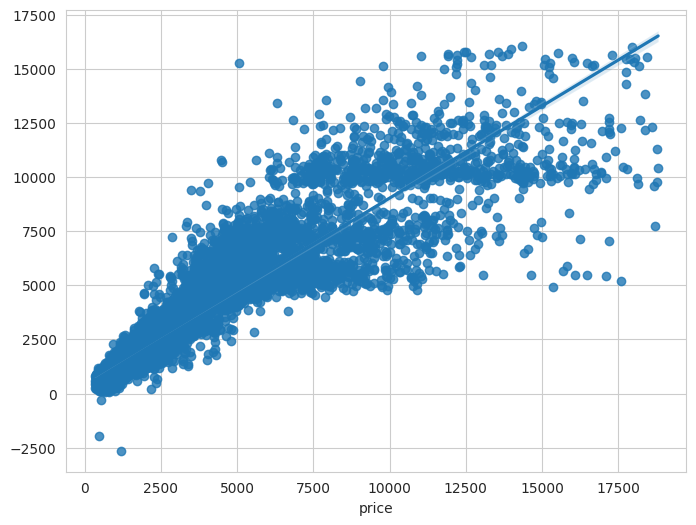

R2 Adjusted R2        MSE    RMSE    MAE
0 0.85        0.85 1788098.42 1337.20 775.88

In [94]:
f_lr_log = train_model(f_lr)
add_to_f_scores_df(f_lr_log, "Linear Regression", 0)
f_lr_log

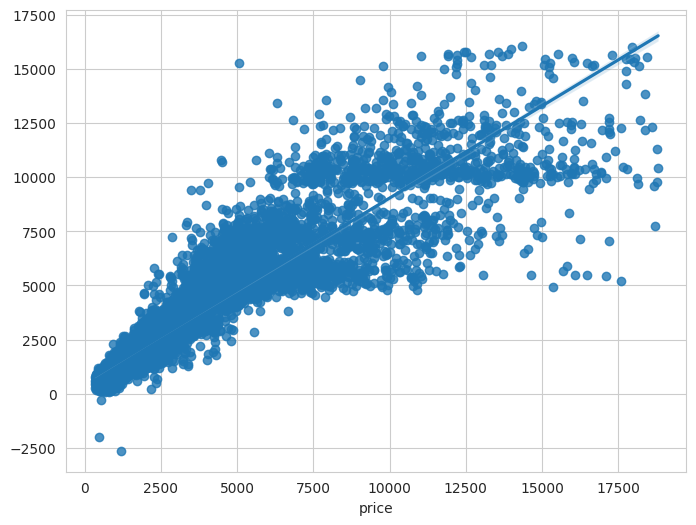

R2 Adjusted R2        MSE    RMSE    MAE
0 0.85        0.85 1788097.77 1337.20 775.57

In [95]:
f_ridge_log = train_model(f_ridge)
add_to_f_scores_df(f_ridge_log, "Ridge", 1)
f_ridge_log

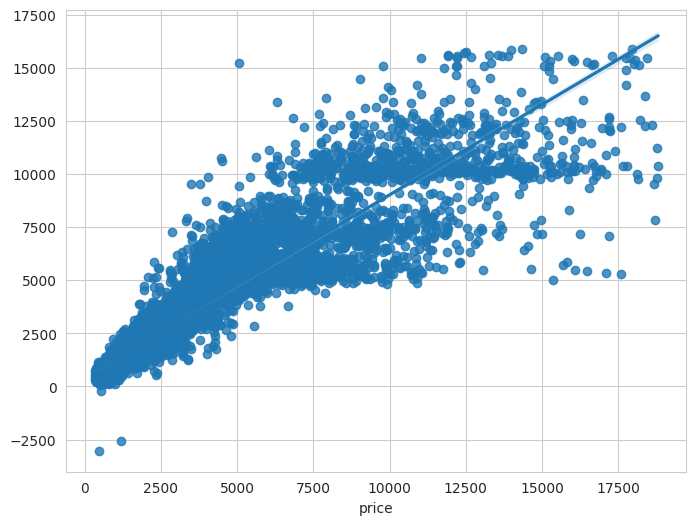

R2 Adjusted R2        MSE    RMSE    MAE
0 0.85        0.85 1790315.33 1338.03 771.08

In [96]:
f_lasso_log = train_model(f_lasso)
add_to_f_scores_df(f_lasso_log, "Lasso", 2)
f_lasso_log

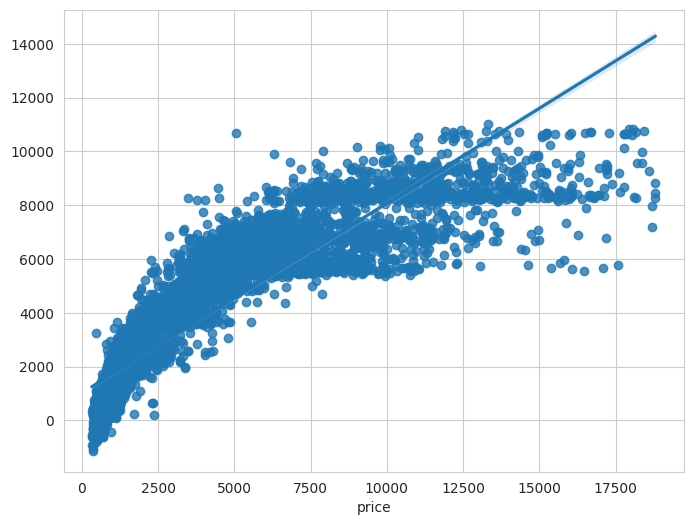

R2 Adjusted R2        MSE    RMSE     MAE
0 0.78        0.78 2567217.96 1602.25 1037.15

In [97]:
f_en_log = train_model(f_en)
add_to_f_scores_df(f_en_log, "ElasticNet", 3)
f_en_log

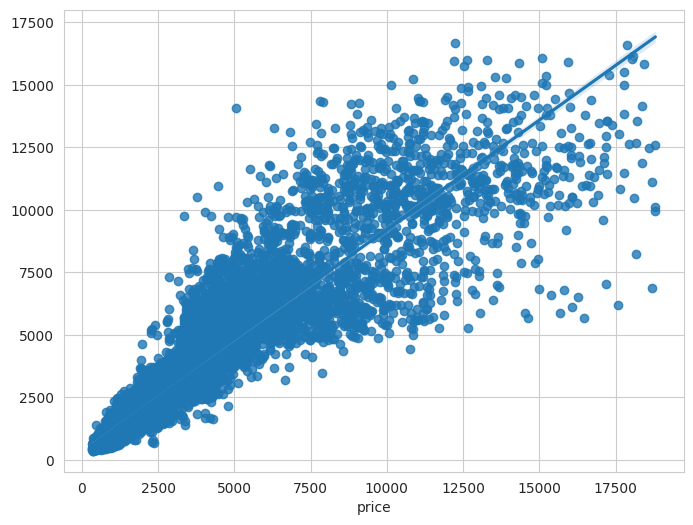

R2 Adjusted R2        MSE    RMSE    MAE
0 0.85        0.85 1789505.77 1337.72 743.38

In [98]:
f_rf_log = train_model(f_rf)
add_to_f_scores_df(f_rf_log, "Random Forests", 4)
f_rf_log

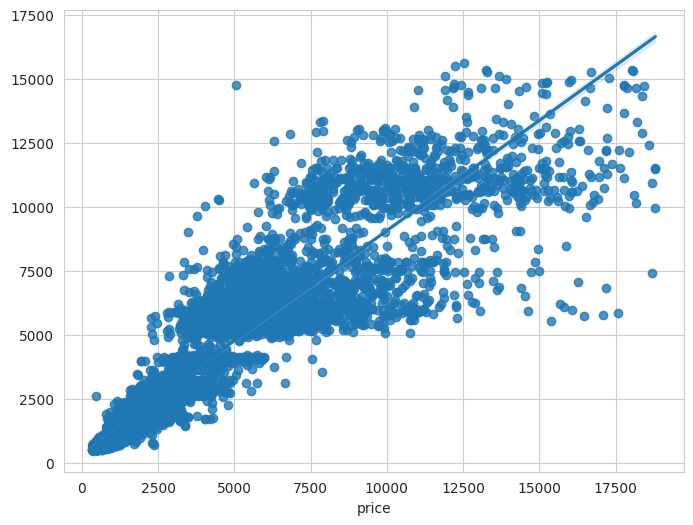

R2 Adjusted R2        MSE    RMSE    MAE
0 0.86        0.86 1651333.71 1285.04 716.05

In [99]:
f_gb_log = train_model(f_gb)
add_to_f_scores_df(f_gb_log, "Gradient Boosting", 5)
f_gb_log

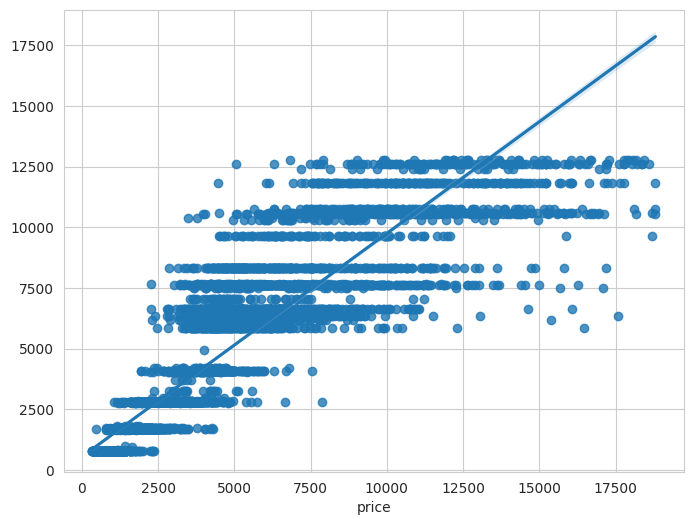

R2 Adjusted R2        MSE    RMSE    MAE
0 0.83        0.83 2062193.12 1436.03 850.32

In [100]:
f_ada_log = train_model(f_ada)
add_to_f_scores_df(f_ada_log, "Ada Boost", 6)
f_ada_log

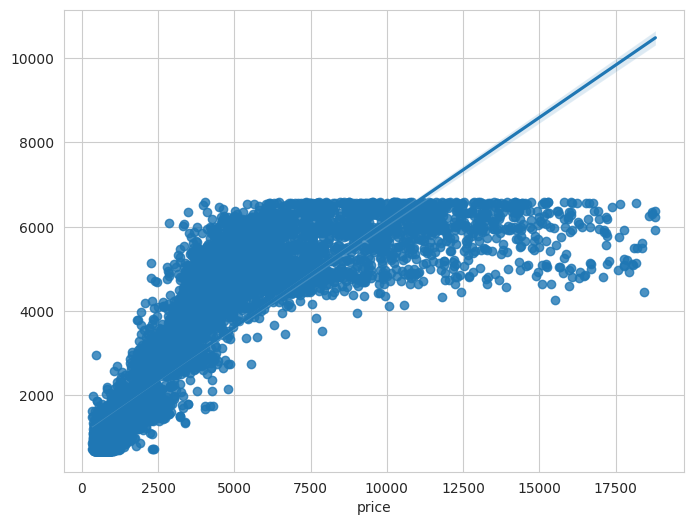

R2 Adjusted R2        MSE    RMSE     MAE
0 0.63        0.63 4370781.64 2090.64 1017.55

In [101]:
f_svr_log = train_model(f_svr)
add_to_f_scores_df(f_svr_log, "SVR", 7)
f_svr_log

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000662 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1027
[LightGBM] [Info] Number of data points in the train set: 38130, number of used features: 5
[LightGBM] [Info] Start training from score 3509.565303


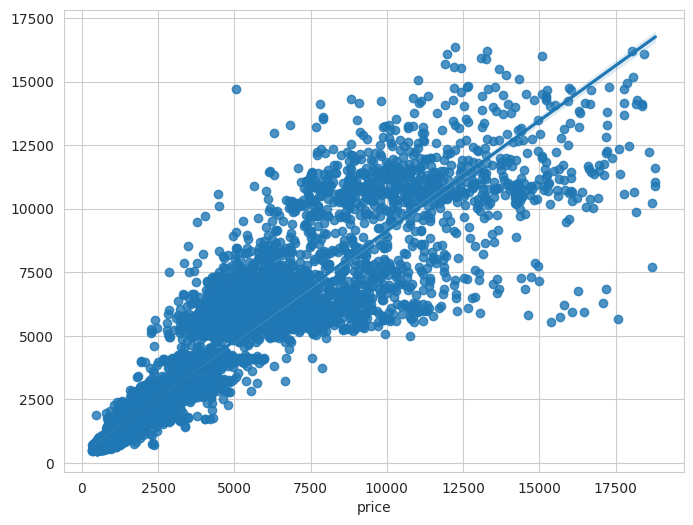

R2 Adjusted R2        MSE    RMSE    MAE
0 0.86        0.86 1644967.53 1282.56 713.86

In [102]:
f_lgbm_log = train_model(f_lgbm)
add_to_f_scores_df(f_lgbm_log, "LGBM", 8)
f_lgbm_log

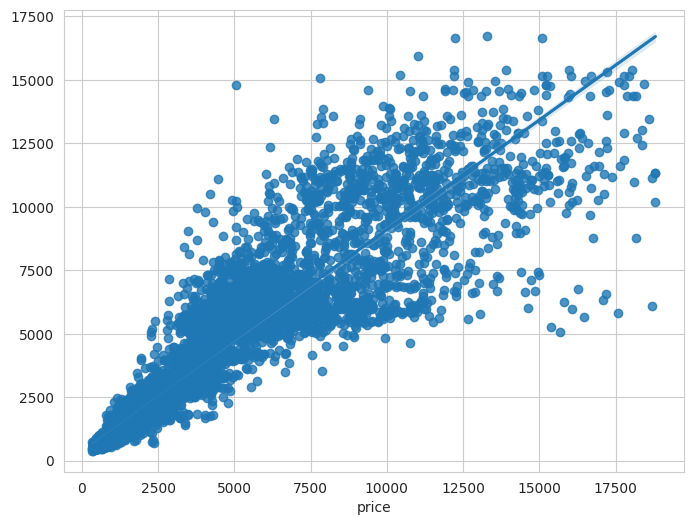

R2 Adjusted R2        MSE    RMSE    MAE
0 0.86        0.86 1708214.29 1306.99 717.12

In [103]:
f_xgb_log = train_model(f_xgb)
add_to_f_scores_df(f_xgb_log, "XGBoost", 9)
f_xgb_log

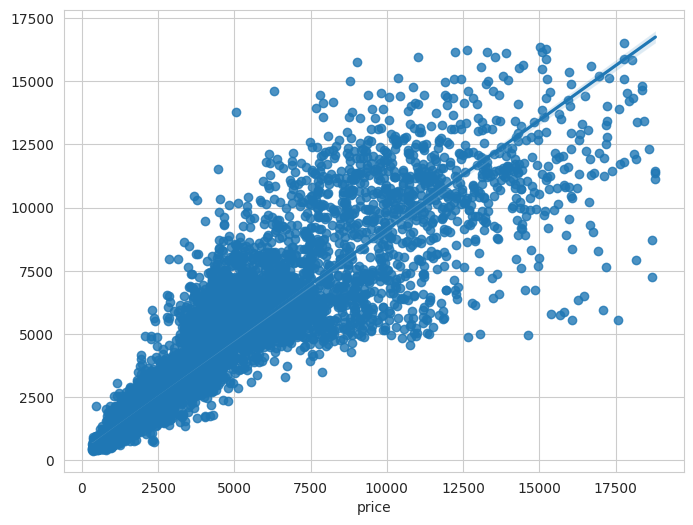

R2 Adjusted R2        MSE    RMSE    MAE
0 0.84        0.84 1882745.77 1372.13 756.01

In [104]:
f_knn_log = train_model(f_knn)
add_to_f_scores_df(f_knn_log, "KNeighbors", 10)
f_knn_log

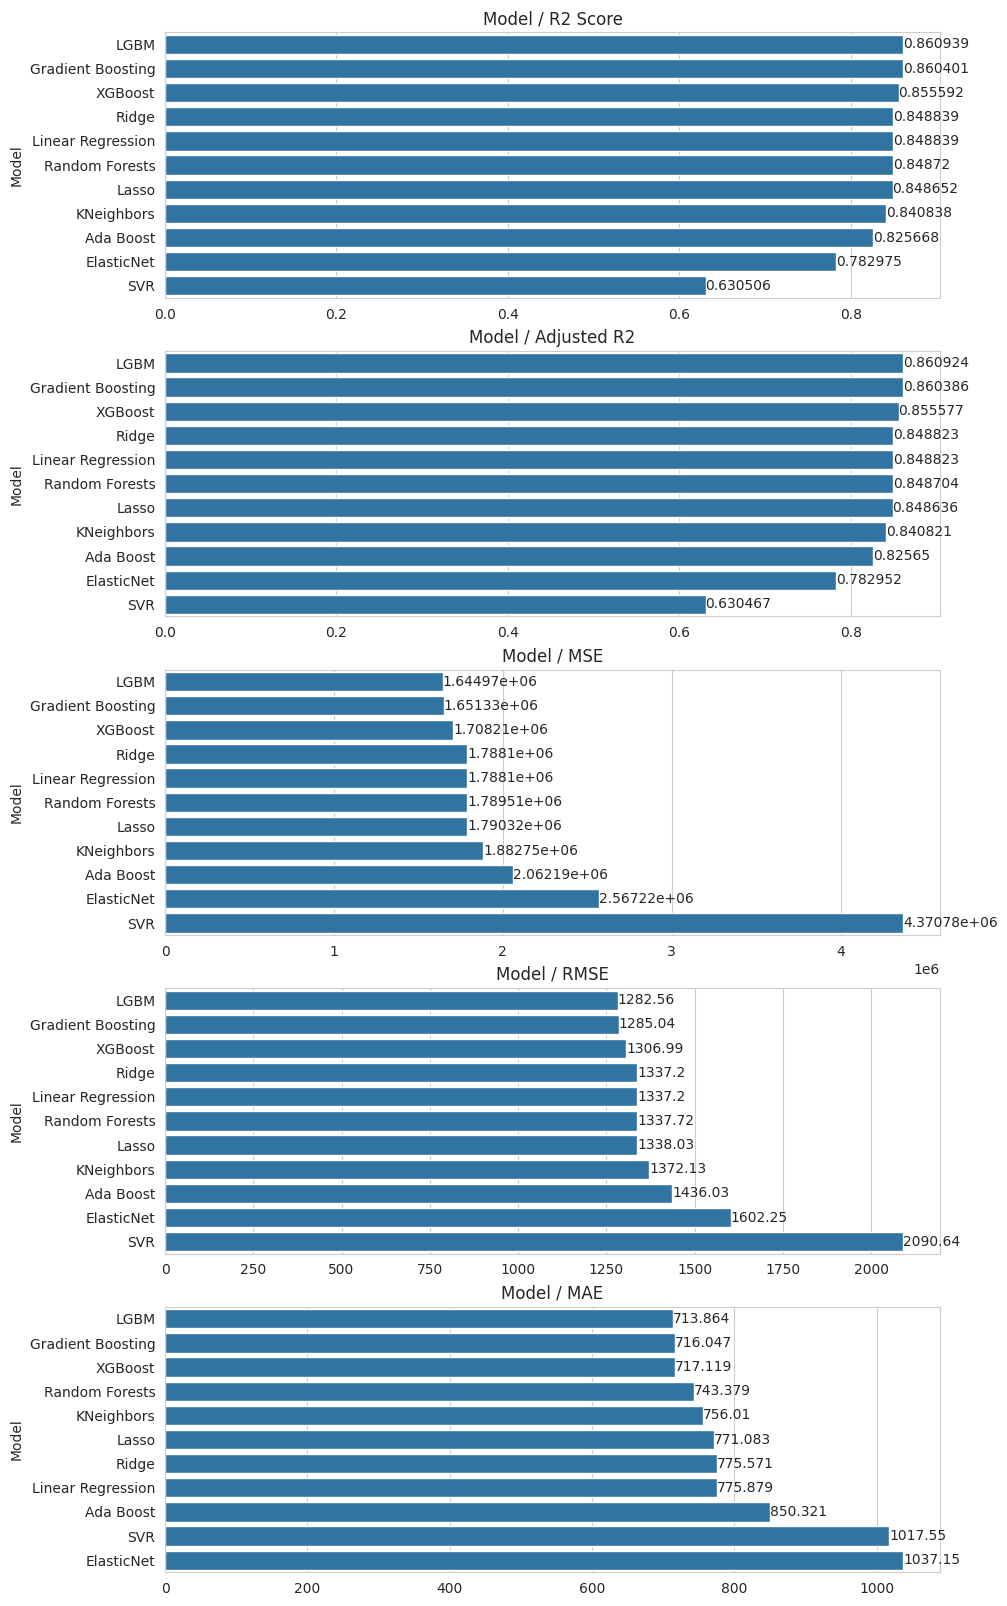

In [105]:
plt.figure(figsize=(10, 20))

plt.subplot(511)
ax = sns.barplot(data=f_scores_df.sort_values(by="R2", ascending=False), y="Model", x="R2")
for container in ax.containers:
    ax.bar_label(container)
plt.title("Model / R2 Score")
plt.xlabel("")

plt.subplot(512)
ax = sns.barplot(data=f_scores_df.sort_values(by="Adjusted R2", ascending=False), y="Model", x="Adjusted R2")
for container in ax.containers:
    ax.bar_label(container)
plt.title("Model / Adjusted R2")
plt.xlabel("")

plt.subplot(513)
ax = sns.barplot(data=f_scores_df.sort_values(by="MSE", ascending=True), y="Model", x="MSE")
for container in ax.containers:
    ax.bar_label(container)
plt.title("Model / MSE")
plt.xlabel("")

plt.subplot(514)
ax = sns.barplot(data=f_scores_df.sort_values(by="RMSE", ascending=True), y="Model", x="RMSE")
for container in ax.containers:
    ax.bar_label(container)
plt.title("Model / RMSE")
plt.xlabel("")

plt.subplot(515)
ax = sns.barplot(data=f_scores_df.sort_values(by="MAE", ascending=True), y="Model", x="MAE")
for container in ax.containers:
    ax.bar_label(container)
plt.title("Model / MAE")
plt.xlabel("")

plt.show()

In [106]:
scores_df

Model   R2  Adjusted R2        MSE    RMSE     MAE
0   Linear Regression 0.76         0.76 2859610.84 1691.04 1385.76
1               Ridge 0.76         0.76 2857137.90 1690.31 1384.99
2               Lasso 0.76         0.76 2814195.64 1677.56 1369.63
3          ElasticNet 0.78         0.78 2612152.31 1616.22 1207.32
4      Random Forests 0.81         0.81 2239791.70 1496.59  800.29
5   Gradient Boosting 0.86         0.86 1662543.93 1289.40  743.17
6           Ada Boost 0.69         0.69 3699992.97 1923.54 1369.02
7                 SVR 0.36         0.36 7610843.89 2758.78 1741.17
8                LGBM 0.82         0.82 2110535.64 1452.77  749.45
9             XGBoost 0.82         0.82 2186786.38 1478.78  766.84
10         KNeighbors 0.82         0.82 2127880.70 1458.73  882.61

In [107]:
f_scores_df

Model   R2  Adjusted R2        MSE    RMSE     MAE
0   Linear Regression 0.85         0.85 1788098.42 1337.20  775.88
1               Ridge 0.85         0.85 1788097.77 1337.20  775.57
2               Lasso 0.85         0.85 1790315.33 1338.03  771.08
3          ElasticNet 0.78         0.78 2567217.96 1602.25 1037.15
4      Random Forests 0.85         0.85 1789505.77 1337.72  743.38
5   Gradient Boosting 0.86         0.86 1651333.71 1285.04  716.05
6           Ada Boost 0.83         0.83 2062193.12 1436.03  850.32
7                 SVR 0.63         0.63 4370781.64 2090.64 1017.55
8                LGBM 0.86         0.86 1644967.53 1282.56  713.86
9             XGBoost 0.86         0.86 1708214.29 1306.99  717.12
10         KNeighbors 0.84         0.84 1882745.77 1372.13  756.01

# Hyperparameter Tuning

In [ ]:
t_scores_df = pd.DataFrame({
    "Model": [],
    "R2": [],
    "Adjusted R2": [],
    "MSE": [],
    "RMSE": [],
    "MAE": []
})

In [ ]:
def add_to_t_scores_df(log, model_name, idx):
    t_scores_df.loc[idx] = [model_name, log["R2"][0], log["Adjusted R2"][0], log["MSE"][0], log["RMSE"][0], log["MAE"][0]]

In [ ]:
rf_params = {
    "bootstrap": [True, False],
    "max_depth": [2, 4, 6, 8],
    "max_features": [0.1, 0.2, 0.5],
    "min_samples_split": [0.1, 0.2, 0.5],
    "n_estimators": [50, 100, 250, 500, 1000]
}

rf_model = RandomForestRegressor()

cv = RandomizedSearchCV(rf_model, rf_params, n_iter=10, cv=3, n_jobs=-1, verbose=0)
cv.fit(X_train_new, y_train)

print("Best hyperparams:\n", cv.best_params_)
print("Best score: ", cv.best_score_)

In [ ]:
rf_tuned = RandomForestRegressor(**cv.best_params_)
rf_tuned_log = train_model(rf_tuned)
add_to_t_scores_df(rf_tuned_log, "Random Forests", 0)
rf_tuned_log

In [ ]:
lgbm_params ={
    'learning_rate':[0.01, 0.1, 0.5],
    'n_estimators':[100,500,1000,1250],
    'colsample_bytree': [0.3, 0.7, 1],
    'max_bin':[100, 250, 300],
    'max_depth':[2, 3, 4, 6],
    'min_data_in_leaf':[10, 20, 50],
    'reg_alpha': [1, 2, 5, 10],
    'reg_lambda': [1, 2, 5, 10],
    'min_gain_to_split':[1, 3, 5, 10]
}

lgbm_model = LGBMRegressor()
cv = RandomizedSearchCV(lgbm_model, lgbm_params, n_iter=10, cv=3, n_jobs=-1, verbose=-1)
cv.fit(X_train_new, y_train)

print("Best hyperparams:\n", cv.best_params_)
print("Best score: ", cv.best_score_)

In [ ]:
lgbm_tuned = LGBMRegressor(**cv.best_params_)
lgbm_tuned = train_model(lgbm_tuned)
add_to_t_scores_df(lgbm_tuned, "LGBM", 1)
lgbm_tuned

In [ ]:
xgb_params = {
    'n_estimators': [100, 250, 500, 1000],
    'booster':['gbtree', 'gblinear'],
    'learning_rate':[0.01, 0.1, 0.5],
    'max_depth':[2, 3, 5, 7, 10],
    'subsample':[0.5, 0.6, 0.7],
    'min_child_weight': [5, 10, 25],
    'gamma':[5, 10, 25, 50],
    'lambda':[5, 10, 25, 50],
}

xgb_model = XGBRegressor()
cv = RandomizedSearchCV(xgb_model, xgb_params, n_iter=10, cv=3, n_jobs=-1, verbose=0)
cv.fit(X_train_new, y_train)

print("Best hyperparams:\n", cv.best_params_)
print("Best score: ", cv.best_score_)

In [ ]:
xgb_tuned = XGBRegressor(**cv.best_params_)
xgb_tuned_log = train_model(xgb_tuned)
add_to_t_scores_df(xgb_tuned_log, "XGBRegressor", 2)
xgb_tuned_log

# Results

In [ ]:
t_scores_df

In [ ]:
plt.figure(figsize=(10, 20))

plt.subplot(511)
ax = sns.barplot(data=t_scores_df.sort_values(by="R2", ascending=False), y="Model", x="R2")
for container in ax.containers:
    ax.bar_label(container)
plt.title("Model / R2 Score")
plt.xlabel("")

plt.subplot(512)
ax = sns.barplot(data=t_scores_df.sort_values(by="Adjusted R2", ascending=False), y="Model", x="Adjusted R2")
for container in ax.containers:
    ax.bar_label(container)
plt.title("Model / Adjusted R2")
plt.xlabel("")

plt.subplot(513)
ax = sns.barplot(data=t_scores_df.sort_values(by="MSE", ascending=True), y="Model", x="MSE")
for container in ax.containers:
    ax.bar_label(container)
plt.title("Model / MSE")
plt.xlabel("")

plt.subplot(514)
ax = sns.barplot(data=t_scores_df.sort_values(by="RMSE", ascending=True), y="Model", x="RMSE")
for container in ax.containers:
    ax.bar_label(container)
plt.title("Model / RMSE")
plt.xlabel("")

plt.subplot(515)
ax = sns.barplot(data=t_scores_df.sort_values(by="MAE", ascending=True), y="Model", x="MAE")
for container in ax.containers:
    ax.bar_label(container)
plt.title("Model / MAE")
plt.xlabel("")

plt.show()